# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

У нас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Предоставленные заказчиком данные для решения задач:

- id — уникальный идентификатор сотрудника;

- dept — отдел, в котором работает сотрудник;

- level — уровень занимаемой должности;

- workload — уровень загруженности сотрудника;

- employment_years — длительность работы в компании (в годах);

- last_year_promo — показывает, было ли повышение за последний год;

- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

- salary — ежемесячная зарплата сотрудника;

- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.



Установим дополнительные библиотеки:

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC

# Задача №1:

# 1) Загрузка данных

In [3]:
df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [4]:
df.sample(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
346,156372,sales,sinior,medium,4,no,no,5,57600,0.65
139,978512,technology,middle,low,4,no,no,4,22800,0.53
2878,832997,marketing,junior,low,1,no,yes,3,13200,0.16
268,292206,hr,middle,medium,9,no,no,3,39600,0.47
3841,784072,purchasing,junior,medium,1,no,no,4,22800,0.52
1645,712099,technology,junior,medium,1,no,no,5,27600,0.51
3451,632683,sales,junior,high,5,no,yes,3,30000,0.40
3313,773522,technology,junior,low,1,no,no,5,19200,0.65
3953,443434,purchasing,junior,medium,1,no,no,4,25200,0.70
1487,211963,purchasing,middle,low,7,no,no,4,19200,0.70


# Вывод по разделу:

1) предоставленные данные соответствуют описанию

2) Типы данных корректны

3) заметны пропуски в данных, есть опечатка в значении s`i`nior

# 2) Предобработка данных

Исправим опечатку:

In [5]:
df['level'] = df['level'].replace('sinior', 'senior')
df['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

Посмотрим, имеются ли пропуски в данных:

In [6]:
df.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пропуски действительно есть, по заданию заполнить их нужно с помощью пайплайна (он будет составлен в одном из следующих шагов)

Обработаем дубликаты:

In [7]:
df.duplicated().sum()

0

In [8]:
df = df.drop('id', axis=1)

In [9]:
df.duplicated().sum()

245

In [10]:
df = df.drop_duplicates().reset_index(drop=True)

In [11]:
df.duplicated().sum()

0

# Вывод по разделу:

1) Исправлены опечатки

2) Обработаны дубликаты

3) Найдены пропуски, которые будут заполнены в пайплайне

# 3) Исследовательский анализ данных

Определим функцию, которая строит распределение данных

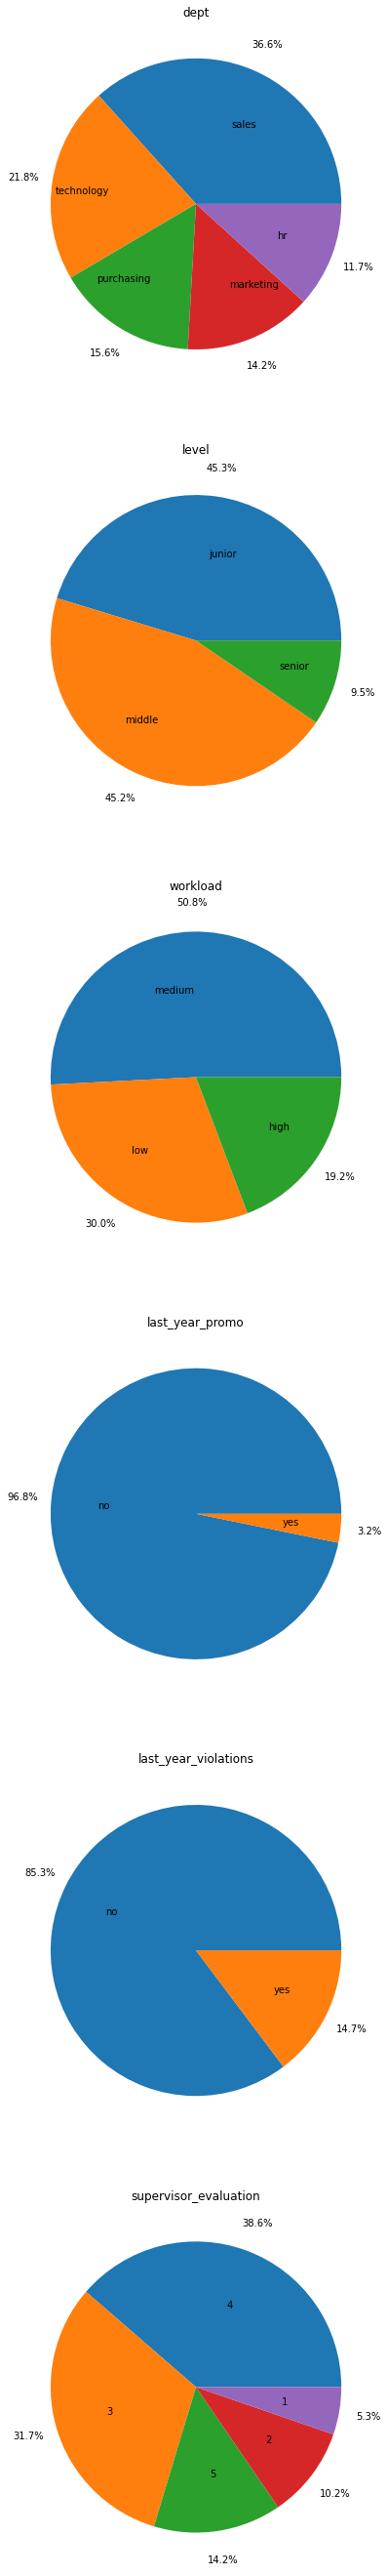

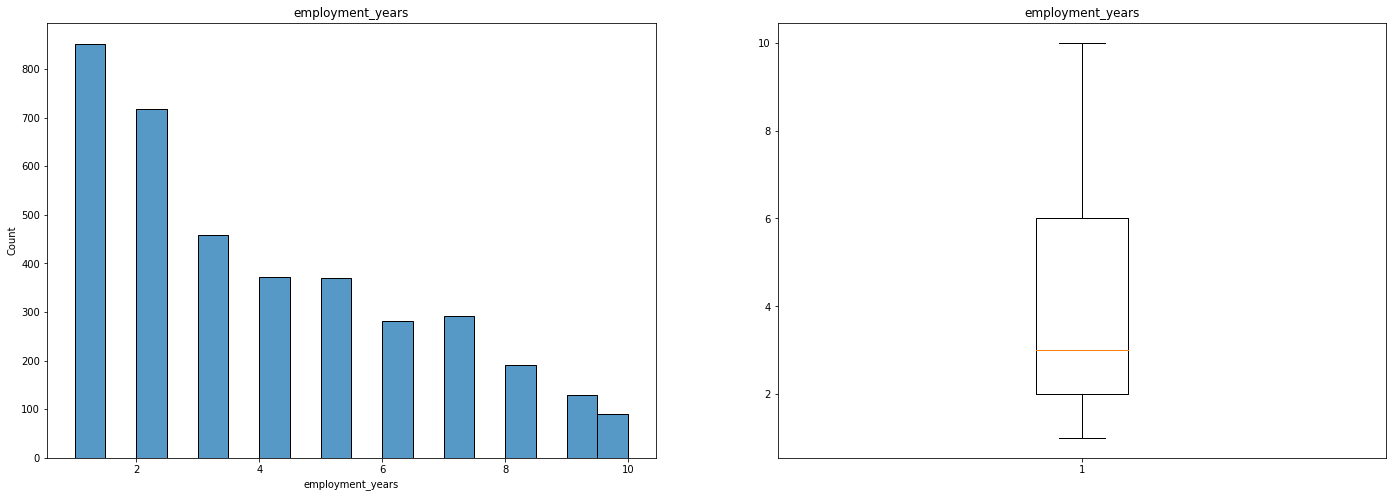

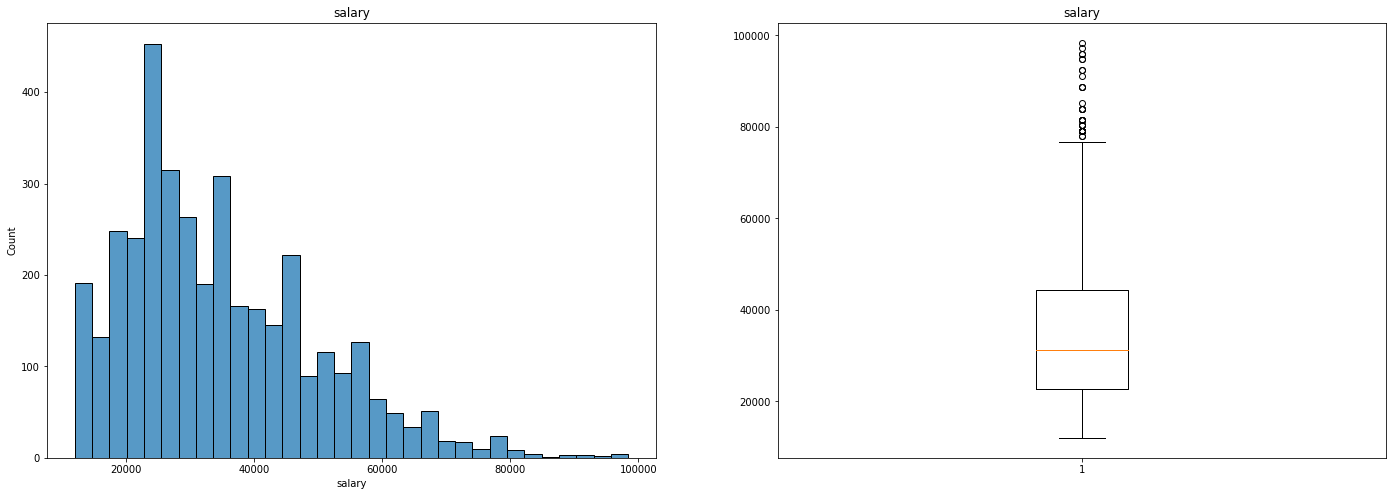

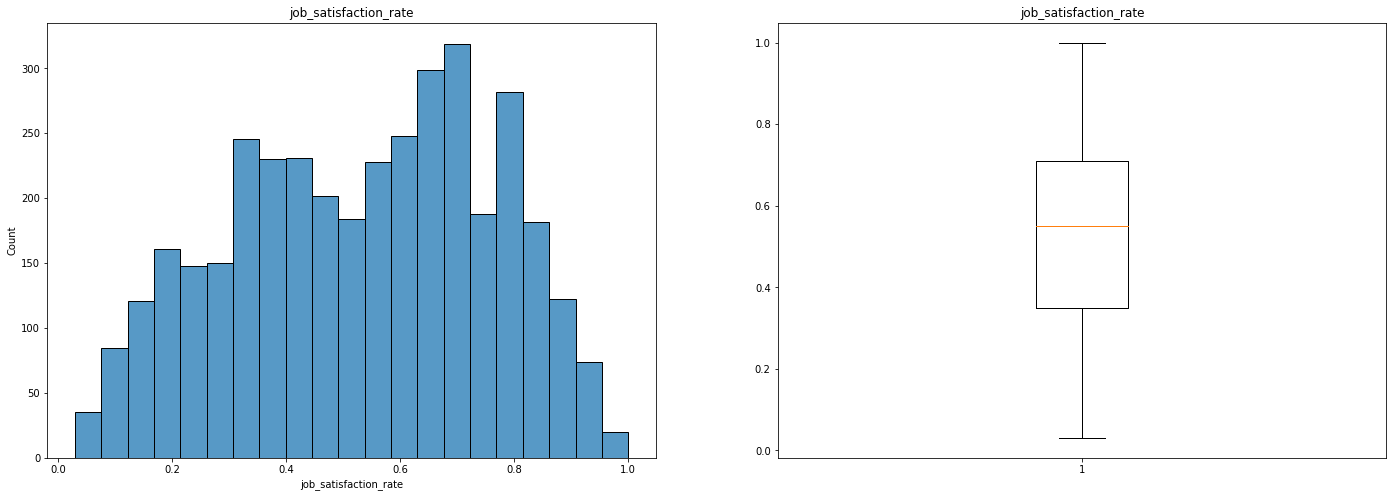

In [12]:
def get_distribution(df):
    cat_col_names = df.select_dtypes(include='object').columns.tolist() + ['supervisor_evaluation']
    num_col_names = df.select_dtypes(exclude='object').columns.tolist()
    num_col_names.remove('supervisor_evaluation')
    
    # отображение распределений категориальных данных
    fig, ax = plt.subplots(len(cat_col_names), 1, figsize=(48, 48))
    for i, cat_col in enumerate(cat_col_names, start=0):
        ax[i].pie(df[cat_col].value_counts().values, labels=df[cat_col].value_counts().index, autopct='%1.1f%%', pctdistance=1.2, labeldistance=.6)
        ax[i].set_title(cat_col)
    
    # отображение распределений количественных данных
    for i, num_col in enumerate(num_col_names, start=0):
        fig, ax = plt.subplots(1, 2, figsize=(24, 8))
        sns.histplot(data=df, ax=ax[0], stat="count", x=num_col, element="bars", legend=True)
        ax[0].set_title(num_col)
        ax[1].boxplot(df[num_col])
        ax[1].set_title(num_col)
        
        
get_distribution(df)

 - Количественные данные не распределены нормально

 - Замечены выбросы в столбце `salary`, вероятно им отвечает зарплаты сотрудников уровня `senior`, удалить эти выбросы нельзя, так как они описывают истинное распределение зарплат в компании
 
 - В компании всего у 3% сотрудников было повышение за прошедший год
 
 - Примерно у половины сотрудников уровень junior

Изучим корреляцию между входными признаками:

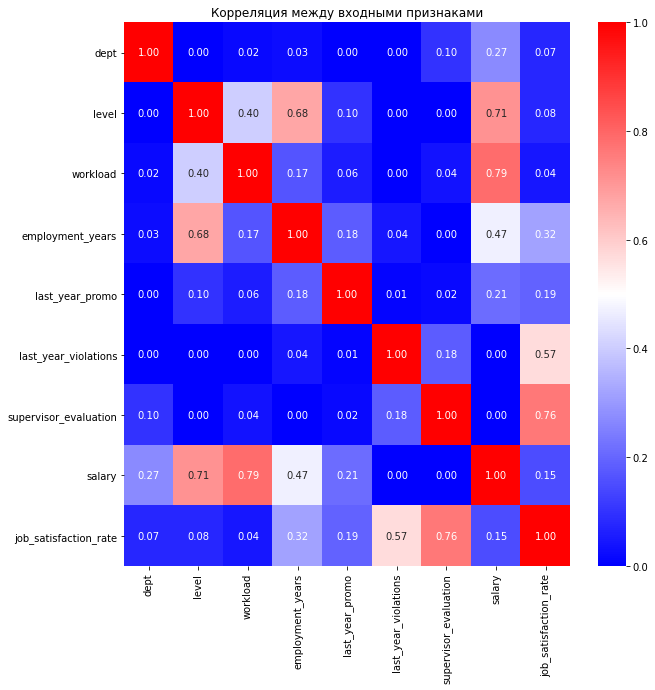

In [13]:
corr = df.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

fig, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt='.2f', cmap="bwr", ax=ax).set(title='Корреляция между входными признаками')
plt.show()

Определим функцию, которая покажет зависимость целевого признака от входного количественного признака в разбиении по категориальным признакам:

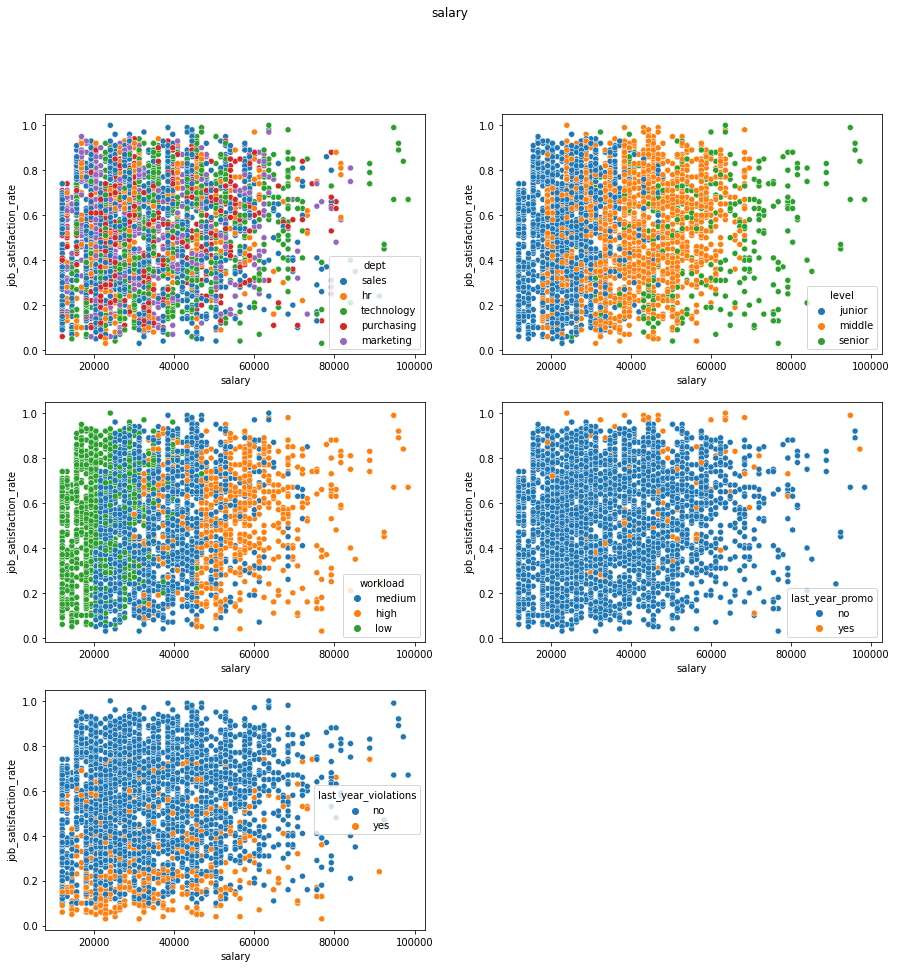

In [14]:
def get_scatterplot(num_feature, cat_features, target):
    fig, axes = plt.subplots(nrows=len(cat_features) // 2 + len(cat_features) % 2, ncols=2, figsize=(15, 15))
    for i, cat_feature in enumerate(cat_features):
        sns.scatterplot(data=df, y=df[target], x=num_feature, hue=cat_feature, ax=axes.flatten()[i])
    if len(cat_features) % 2 == 1:
        fig.delaxes(axes[-1, -1])
    plt.suptitle(num_feature)
    
        
get_scatterplot('salary', df.select_dtypes(include='object').columns.tolist(), 'job_satisfaction_rate')

По полученным графикам можно сделать вывод о том, что целевой признак зависит нелинейно от признака `salary`

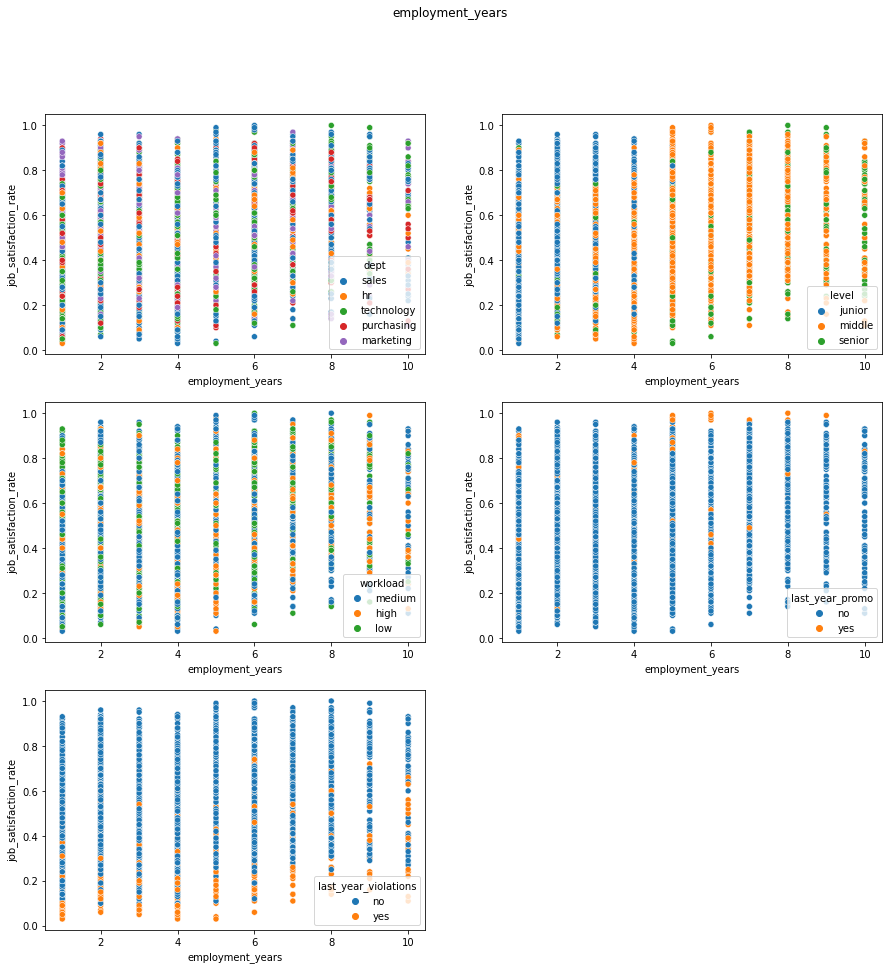

In [15]:
get_scatterplot('employment_years', df.select_dtypes(include='object').columns.tolist(), 'job_satisfaction_rate')

По полученным графикам можно сделать вывод о том, что целевой признак зависит нелинейно от признака `employment_years`

# Вывод по разделу:

1) были построены распределения для всех данных

2) Количественные данные не распределены нормально

3) Замечены выбросы в столбце `salary`, вероятно им отвечает зарплаты сотрудников уровня `senior`, удалить эти выбросы нельзя, так как они описывают истинное распределение зарплат в компании

4) В исходных даных нет мультиколлинеарности

5) Данные распределены нелинейно относительно целевого признака

# 4) - 5) Подговка данных и обучение моделей

Определим метрику SMAPE:

In [16]:
def smape(y_true, y_pred):
    y_true = y_true.values
    return (100 / len(y_true)) * sum(2 * np.abs(y_t - y_p) / (np.abs(y_t) + np.abs(y_p)) for y_t, y_p in zip(y_true, y_pred))


smape_scorer = make_scorer(smape, greater_is_better=False)

Составим полный пайплайн (подготовка данных и обучение моделей):

In [17]:
RANDOM_STATE = 7

X_train, y_train = df.drop('job_satisfaction_rate', axis=1), df['job_satisfaction_rate']

# создаём списки с названиями признаков
ohe_columns = X_train.select_dtypes(include='object').columns.tolist()
num_columns = X_train.select_dtypes(exclude='object').columns.tolist()

ohe_pipe = Pipeline(
    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ]
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
                    ]), 
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ])
        ]
    },
    

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
                    ]), 
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ])
        ]  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели при кросс-валидации:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
       

In [18]:
X_y = pd.read_csv('/datasets/test_features.csv').merge(pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv'), on='id')

X_test = X_y.drop(['job_satisfaction_rate'], axis=1).replace('sinior', 'senior')
y_test = X_y['job_satisfaction_rate']

-smape_scorer(randomized_search, X_test, y_test)

14.183488711581951

In [20]:
feature_importances = pd.DataFrame(
    {
        'Feature': randomized_search.best_estimator_[0].get_feature_names_out(),
        'Importance': randomized_search.best_estimator_[1].feature_importances_
    })

# сортируем таблицу по важности — от большей к меньшей
print(feature_importances.sort_values('Importance', ascending=False))

                          Feature  Importance
11     num__supervisor_evaluation    0.582126
9   ohe__last_year_violations_yes    0.168325
10          num__employment_years    0.072442
12                    num__salary    0.065291
4               ohe__level_middle    0.039377
5               ohe__level_senior    0.014369
0             ohe__dept_marketing    0.012854
2                 ohe__dept_sales    0.010736
6               ohe__workload_low    0.009541
8        ohe__last_year_promo_yes    0.008518
7            ohe__workload_medium    0.008303
3            ohe__dept_technology    0.007179
1            ohe__dept_purchasing    0.000939


# Вывод по разделу:

1) Построен полный пайплайн, который подготавливает данные и обучает на них модели

2) Создана функция, считающая метрику SMAPE

3) Лучшей моделью стало дерево решений `DecisionTreeRegressor(max_depth=11, max_features=9, min_samples_leaf=7, min_samples_split=3, random_state=7)`
   Метрика SMAPE на тестовой выборке составляет 14.18 $<= 15$
   Оно справилось лучше, чем линрег так как входные признаки не были связаны линейно с целевым (это было выяснено в шаге исследовательскго анализа данных)

# Задача №2

# 1) Загрузка данных

In [21]:
df = pd.read_csv('/datasets/train_quit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [22]:
df.sample(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
1797,132275,purchasing,junior,medium,4,no,yes,2,27600,yes
1361,676067,sales,junior,low,4,no,no,3,12000,yes
3662,991373,sales,middle,high,1,no,yes,4,57600,no
2633,497800,sales,middle,medium,10,no,no,4,38400,yes
2177,652133,hr,junior,medium,3,no,no,3,28800,yes
63,498438,technology,junior,medium,4,no,no,4,34800,no
987,929635,marketing,junior,low,1,no,no,4,13200,yes
3405,403503,marketing,junior,medium,1,no,no,4,25200,yes
362,180125,sales,middle,medium,8,no,no,4,43200,no
3538,706455,marketing,junior,high,2,no,no,3,33600,yes


# Вывод по разделу:

1) предоставленные данные соответствуют описанию

2) Типы данных корректны

# 2) Предобработка данных

Исправим опечатку:

In [23]:
df['level'] = df['level'].replace('sinior', 'senior')
df['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

Поищем пропуски:

In [24]:
df.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Поищем дубликаты:

In [25]:
df.duplicated().sum()

0

In [26]:
df = df.drop('id', axis=1)

In [27]:
df.duplicated().sum()

1413

In [28]:
df = df.drop_duplicates().reset_index(drop=True)

In [29]:
df.duplicated().sum()

0

# Вывод по разделу:

1) Исправлены опечатки

2) Обработаны дубликаты и пропуски

# 3.1) Исследовательский анализ данных

Построим распределение данных:

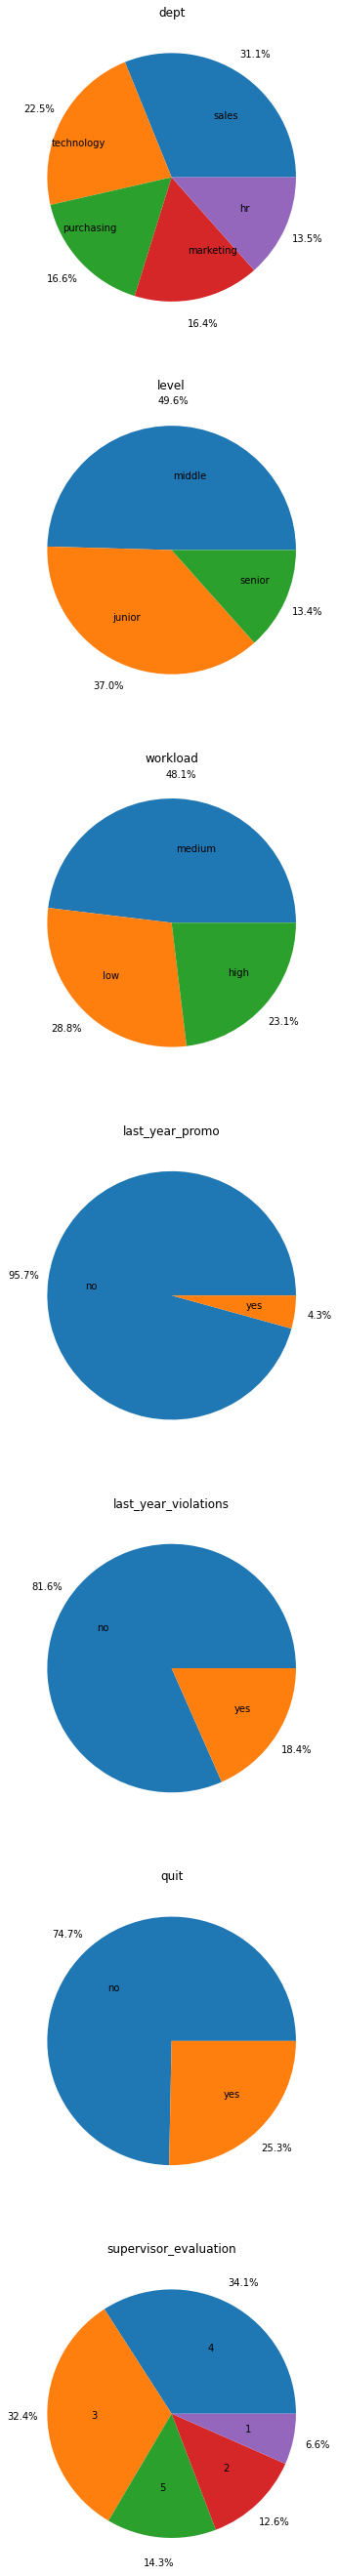

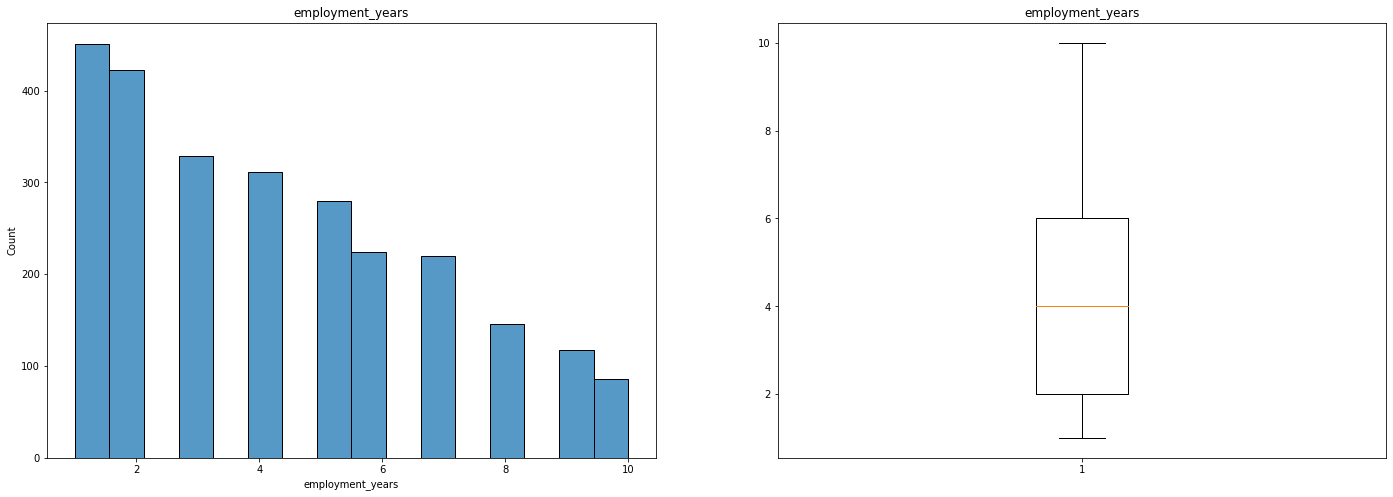

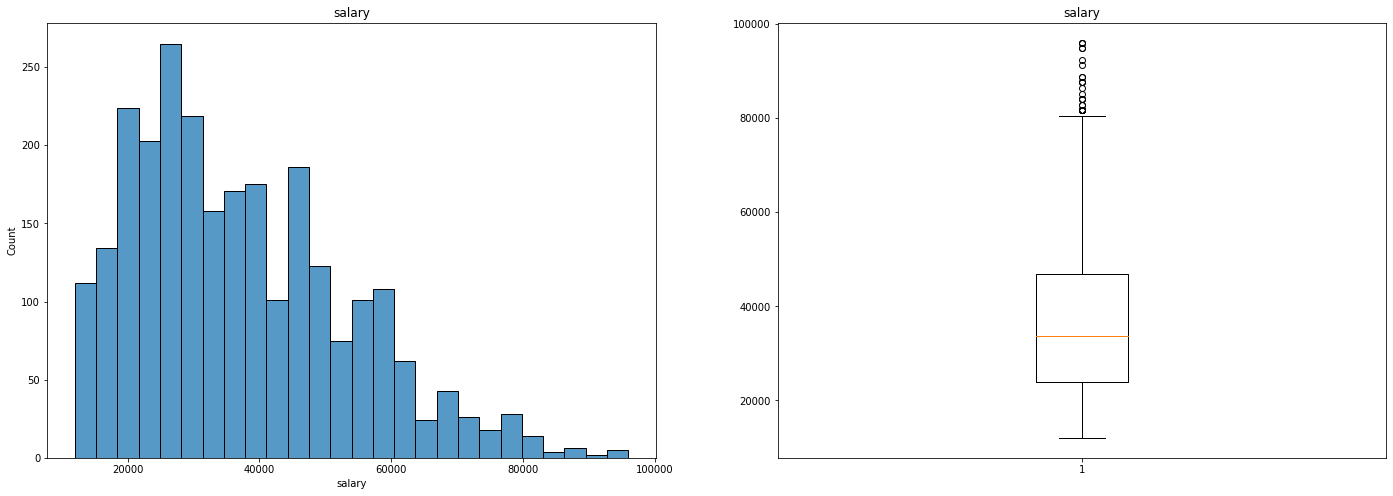

In [30]:
get_distribution(df)

 - Количественные данные не распределены нормально

 - Замечены выбросы в столбце `salary`, вероятно им отвечает зарплаты сотрудников уровня `senior`, удалить эти выбросы нельзя, так как они описывают истинное распределение зарплат в компании
 
 - В компании всего у 3% сотрудников было повышение за прошедший год
 
 - Примерно у половины сотрудников уровень junior

Проведём корреляционный анализ данных:

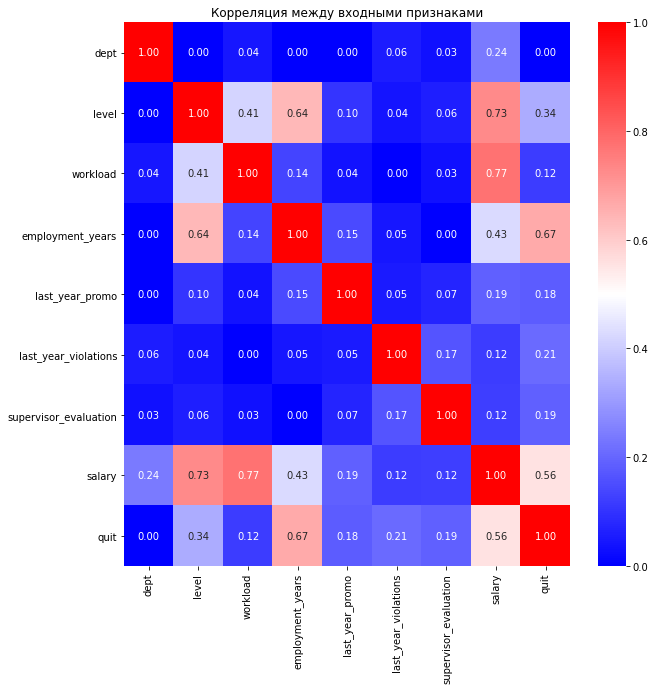

In [31]:
corr = df.phik_matrix(interval_cols=['salary'])

fig, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt='.2f', cmap="bwr", ax=ax).set(title='Корреляция между входными признаками')
plt.show()

# Вывод по разделу:

1) были построены распределения для всех данных

2) Количественные данные не распределены нормально

3) Замечены выбросы в столбце `salary`, вероятно им отвечает зарплаты сотрудников уровня `senior`, удалить эти выбросы нельзя, так как они описывают истинное распределение зарплат в компании

4) В исходных даных нет мультиколлинеарности

5) В целевом признаке наблюдается дисбаланс классов 

# 3.2) Составление портрета уволившегося сотрудника

Определим в каком отделе больше всего увольнений сотрудников:

In [32]:
df[df['quit'] == 'yes']['dept'].value_counts(normalize=True)

sales         0.291603
technology    0.229008
purchasing    0.183206
marketing     0.170992
hr            0.125191
Name: dept, dtype: float64

Сравним средние зарплаты по отделам:

In [33]:
df.pivot_table(index='dept', values='salary', aggfunc='mean').sort_values(by='salary', ascending=False)

,salary
dept,
technology,41442.340792
marketing,37446.808511
sales,35584.099379
hr,35448.275862
purchasing,35112.558140


Определим уровень загруженности у уволившихся сотрудников из отдела продаж:

In [34]:
df[(df['quit'] == 'yes') & (df['dept'] == 'sales')]['workload'].value_counts(normalize=True)

low       0.418848
medium    0.376963
high      0.204188
Name: workload, dtype: float64

Сравним средние зарплаты уволившихся сотрудников и тех, кто остался в компании:

In [35]:
df[df['quit'] == 'yes']['salary'].mean()

25767.93893129771

In [36]:
df[df['quit'] == 'no']['salary'].mean()

40952.17391304348

Видно, что у уволившихся средняя зарплата намного меньше

Посмотрим на уровень должности уволившихся сотрудников:

In [37]:
df[df['quit'] == 'yes']['level'].value_counts(normalize=True)

junior    0.819847
middle    0.154198
senior    0.025954
Name: level, dtype: float64

Львиную долю уволившихся составляют сотрудники уровня junior, вероятно из-за плохих зарплат или высоких требований 

# Вывод по разделу:

Составлен портрет уволившихся сотрудников:

1) Больше всего увольнений произошло в отделе продаж

2) Средняя зарплата отдела продаж меньше всех по сравнению с другими отделами

3) Подавляющее число уволившихся - сотрудники уровня junior

4) У уволившихся сотрудников средняя зарплата намного меньше, вероятно это основная причина увольнения

# 3.3) Визуализация и сравнение распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников

Будем использовать данные с обоими целевыми признаками тестовой выборки:

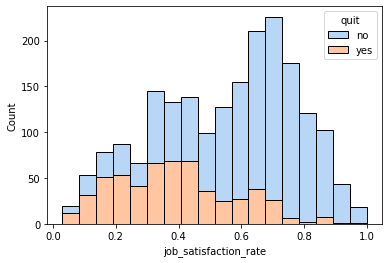

In [38]:
rate_quit = \
    pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv').merge(pd.read_csv('/datasets/test_target_quit.csv'), on='id')

sns.histplot(data=rate_quit, 
             stat="count", 
             multiple="stack", 
             x='job_satisfaction_rate', 
             kde=False, palette="pastel", 
             hue='quit', 
             element="bars", 
             legend=True)
plt.show()

In [39]:
rate_quit.pivot_table(index='quit', values='job_satisfaction_rate', aggfunc='mean')

,job_satisfaction_rate
quit,
no,0.612040
yes,0.387713


Видно, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Чем больше уровень удовлетворённости, тем выше шанс, что сотрудник останется в компании

# 4) Добавление нового входного признака

In [40]:
X_y = pd.read_csv('/datasets/train_quit.csv')
X_train = X_y.drop(['id', 'quit'], axis=1).replace('sinior', 'senior')
y_train = X_y['quit']

X_train['job_satisfaction_rate'] = randomized_search.predict(X_train)
X_train

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.657619
1,sales,junior,medium,2,no,no,4,27600,0.828475
2,purchasing,middle,medium,5,no,no,1,37200,0.347143
3,sales,junior,medium,2,no,yes,3,24000,0.340000
4,marketing,junior,medium,2,no,no,5,25200,0.828475
...,...,...,...,...,...,...,...,...,...
3995,sales,junior,medium,4,no,no,3,26400,0.520476
3996,sales,middle,high,9,no,no,4,52800,0.835000
3997,purchasing,junior,low,2,no,yes,4,12000,0.544286
3998,purchasing,middle,medium,2,no,no,4,33600,0.504667


In [41]:
X_y = pd.read_csv('/datasets/test_features.csv').merge(pd.read_csv('/datasets/test_target_quit.csv'), on='id')

X_test = X_y.drop(['id', 'quit'], axis=1).replace('sinior', 'senior')
y_test = X_y['quit']

X_test['job_satisfaction_rate'] = randomized_search.predict(X_test)
X_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.828475
1,hr,junior,medium,1,no,no,4,30000,0.671228
2,sales,middle,low,5,no,no,4,19200,0.683750
3,sales,middle,low,6,no,no,4,19200,0.686250
4,hr,middle,medium,5,no,no,5,40800,0.816098
...,...,...,...,...,...,...,...,...,...
1995,marketing,junior,low,3,no,no,3,20400,0.531250
1996,technology,middle,low,3,no,no,2,21600,0.217273
1997,technology,junior,low,1,no,no,3,14400,0.230909
1998,technology,middle,low,8,no,no,1,32400,0.518571


# 5) - 6) Подготовка данных и обучение моделей

In [42]:
RANDOM_STATE = 7

# создаём списки с названиями признаков
ohe_columns = X_train.select_dtypes(include='object').columns.tolist()
num_columns = X_train.select_dtypes(exclude='object').columns.tolist()

ohe_pipe = Pipeline(
    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ]
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ordinal', OrdinalEncoder(handle_unknown='error'))
                    ]), 
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ])
        ]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ordinal', OrdinalEncoder(handle_unknown='error'))
                    ]), 
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ])
        ]  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ordinal', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ]), 
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ])
        ]  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(kernel='poly', random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe': [
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ordinal', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ]), 
            Pipeline(
                    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('simpleImputer_ohe2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ])
        ] 
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
       

In [43]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9221321292400086


Построим диаграмму важности каждого из входных признаков:

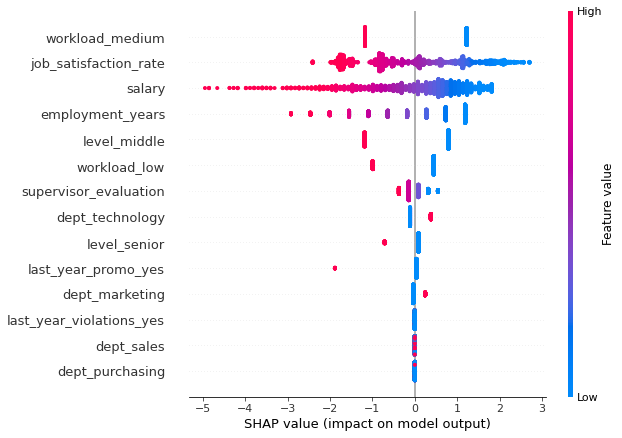

In [44]:
X_test_p = pd.DataFrame(
    randomized_search.best_estimator_[0].transform(X_test),
    columns=randomized_search.best_estimator_[0].transformers_[0][1].get_feature_names_out().tolist() + \
            randomized_search.best_estimator_[0].transformers_[1][1].get_feature_names_out().tolist()
)

explainer = shap.LinearExplainer(randomized_search.best_estimator_[1], X_test_p)
shap_values = explainer(X_test_p)
shap.plots.beeswarm(shap_values, max_display=50)

Видно, что сильнозначимыми являются следующие признаки: `salary` и `job_satisfaction_rate`

# Вывод по разделу:

1) Построен полный пайплайн, который подготавливает данные и обучает на них модели

2) Лучшей моделью стала логистическая регрессия `LogisticRegression(C=2, penalty='l1', random_state=7, solver='liblinear')`
   Метрика ROC-AUC на тестовой выборке составляет 0.92 $>= 0.91$
   
3) Наиболее важные признаки: `salary` и `job_satisfaction_rate`

# Итоговый вывод:

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Этапы решения задачи №1:

В нашем распоряжении были таблицы `train_job_satisfaction_rate.csv`, `test_features.csv`, `test_target_job_satisfaction_rate.csv`
1) Обработка и анализ данных: 

    - устранены опечатки
    - обработаны пропуски и устранены дубликаты
    - были построены распределения для всех данных
    - проанализирована корреляция входных признаков
    
2) Поиск лучшей модели:

    - Для решения задачи было использовано две модели: DecisionTreeRegressor, LinearRegression
    - составлен пайплайн, который обрабатывает пропуски, кодирует категориальные признаки, масштабирует количественные, а затем обучает модели и выявляет среди них лучшую по наименьшему значению метрики SMAPE
    - Лучшей моделью оказалась модель DecisionTreeRegressor(max_depth=11, max_features=9, min_samples_leaf=7, min_samples_split=3, random_state=7). Метрика SMAPE на тренировочной выборке: 15.49, на тестовой - 14.70. Наиболее значимым признаком оказался признак supervisor_evaluation

Этапы решения задачи №2:

В нашем распоряжении были таблицы `train_quit.csv`, `test_features.csv`, `test_target_quit.csv`

1) Обработка и анализ данных: 

    - устранены опечатки
    - обработаны пропуски и устранены дубликаты
    - были построены распределения для всех данных
    - проанализирована корреляция входных признаков
    
2) Составление портрета уволившегося сотрудника:

    В ходе анализа были выяснены следующие факты:
    - Больше всего увольнений произошло в отделе продаж
    - Средняя зарплата отдела продаж меньше всех по сравнению с другими отделами
    - Подавляющее число уволившихся - сотрудники уровня junior
    - У уволившихся сотрудников средняя зарплата намного меньше, вероятно это основная причина увольнения
    
3) Поиск лучшей модели:

    - Для решения задачи были использованы четыре модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и  SVC
    - составлен пайплайн, который обрабатывает пропуски, кодирует категориальные признаки, масштабирует количественные, а затем обучает модели и выявляет среди них лучшую по наивысшему значению метрики ROC-AUC
    - Лучшей моделью оказалась модель LogisticRegression(C=2, penalty='l1', random_state=7, solver='liblinear'), метрика ROC-AUC на тренировочной выборке ~0.93, на тестовой - ~0.92. Наиболее важными признаками оказались признаки salary и job_satisfaction_rate
    
    
Рекомендации для бизнеса:

1) Следует обратить внимание на условия работы и зарплаты стажёров, так как больше всего увольнений с их стороны

2) Большего всего увольнений в отделе продаж, вероятно там что-то не так :)

3) Так же стоит иметь ввиду, что уровень удовлетворённости сотрудника действительно влияет на вероятность увольнения, поэтому стоит сделать всё возможное для его повышения